# miDHM Object Reconstruction Numerical Algorithm


In [1519]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import scipy
from scipy.integrate import simps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.restoration import unwrap_phase
from mpl_toolkits.mplot3d import Axes3D

#from phase_unwrap import *

In [1520]:
# Load image into Python
addpath = ('/Users/charlyk/Desktop/Dissertation/Codes/pyth/Images/04.10.23._20.18/')

# Load the RGB hologram image
# rgb_image = Image.open("example.jpg")
#img = Image.open(addpath+'obj_17.tif').convert("L")
img = Image.open(addpath+'obj_3.tif')
ref = Image.open(addpath+'obj_1.tif')

# Convert the RGB image to grayscale
# gray_image = rgb_image.convert("L")
img = img.convert("L")
ref = ref.convert("L")

# Convert the image to a NumPy array
img = np.asarray(img)/255                  # convert the images into array
ref = np.asarray(ref)/255

#img = img[1450:2050, 1350:1950]
#ref = ref[1450:2050, 1350:1950]


#img = img[800:1300, 1700:2200]
#ref = ref[800:1300, 1700:2200]

In [1521]:
img.shape, ref.shape


((2464, 3264), (2464, 3264))

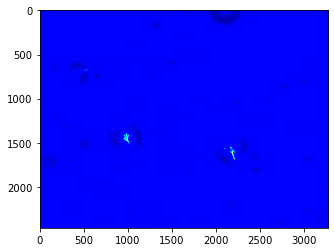

In [1522]:
# Display result
plt.tight_layout()
plt.imshow(abs(img), cmap = 'jet')

In [1523]:
# supression of the DC term
imgH = (img - ref) / (np.sqrt(ref))

#imgH = img - np.mean(img)

# imgH = np.sqrt(image_normalized)


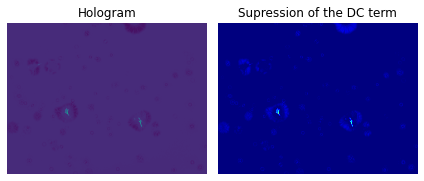

In [1524]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2) 

# Display the images on respective subplots
axes[0].imshow(img)
axes[1].imshow(abs(imgH), cmap = 'jet')

# Optionally, you can add titles to each subplot
axes[0].set_title('Hologram')
axes[1].set_title('Supression of the DC term')

# Optionally, you can remove the ticks on the axes if needed
axes[0].axis('off')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# plt.savefig("subplot_images.png") # To save the plot to a file

In [1525]:
# Set the physical parameters
Ny,Nx = imgH.shape

Lambda = 488e-9            # wavelength of the light source
k = 2*np.pi/Lambda         # wavenumber
dx = 1.12e-6               # pixel size of the camera in the x-coord
dy = dx

# Define the spatial and frequency/spectral sampling intervals and coords
nx = np.arange((-Nx/2),(Nx/2) , dtype = float)
ny = np.arange((-Ny/2),(Ny/2) , dtype = float)

# Spatial sampling
x = nx*dx
y = ny*dy

# Frequency sampling
dfx = 1/(Nx *dx)
dfy = 1/(Ny *dy)

fx = nx*dfx
fy = ny*dfy
Fx,Fy = np.meshgrid(fx,fy)

Text(0.5, 1.0, 'Fourier Spectrum of the sample')

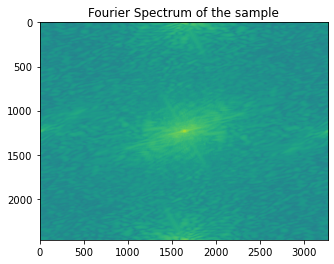

In [1526]:
# Perform the Fourier transformation on the processed hologram 
FimgH = fftshift(fft2(imgH))
# FimgH = FimgH - np.mean(FimgH) 

plt.tight_layout()
plt.imshow(np.log(abs(FimgH)))
plt.title('Fourier Spectrum of the sample')

In [1527]:
d = 7e-3
#d = (Nx * dx**2) / Lambda


# Propagate to the twin image using the Angular Spectrum Method (ASM)
prop = np.exp((1j*2*np.pi*d)*np.sqrt(1/(Lambda**2) - Fx**2 - Fy**2))

Text(0.5, 1.0, 'Transfer function (ASM)')

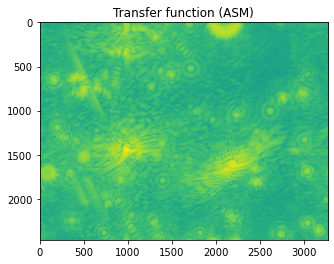

In [1528]:
#  trasfer function the wave field
t = (ifft2(fftshift(FimgH*prop)))

plt.tight_layout()
plt.imshow(np.log(abs(t)))
plt.title('Transfer function (ASM)')

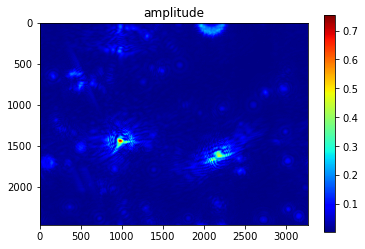

In [1529]:
# display results
amp = (abs(t))                   # amplitude

# Visualize the amplitude
plt.tight_layout()
plt.imshow(amp, cmap='jet')
plt.colorbar()
plt.title('amplitude')
plt.savefig('ampp.tif')

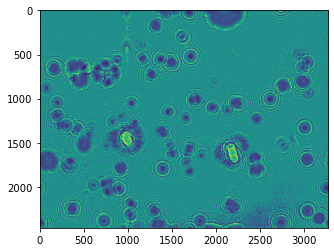

In [1530]:
phi = np.angle(t)              # wrapped phase

# Visualize the phase 
plt.tight_layout()
plt.imshow(phi)
#plt.colorbar()
#plt.title('wrapped phase with the twin-image')
plt.savefig('twin_image.tif') # To save the plot to a file

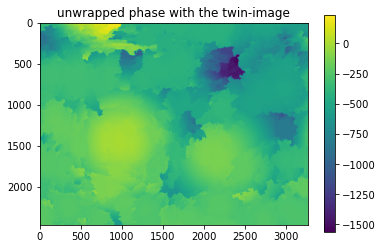

In [1531]:
UnimgH = -unwrap_phase(phi)     # unwrapped phase

# Visualize the phase 
plt.tight_layout()
plt.imshow(UnimgH)
plt.colorbar()
plt.title('unwrapped phase with the twin-image')
plt.savefig('unwrap phase.tif')

### Segment the twin-image


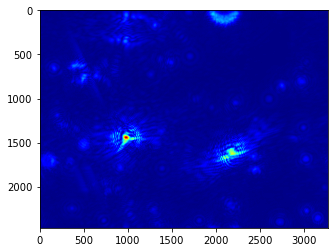

In [1532]:
# 
n = 5
R_TI = amp
R_TI_padded = np.hstack([np.vstack([R_TI, np.zeros((n-1,R_TI.shape[1]))]),\
                                          np.zeros((R_TI.shape[0]+n-1,n-1))])
plt.tight_layout()
plt.imshow(R_TI_padded, cmap = 'jet');

0.0003880457079214838

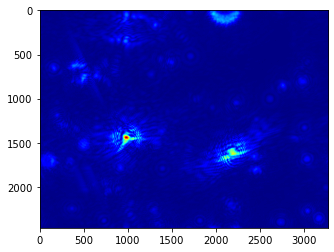

In [1533]:
# the averages
mu = np.sum(np.lib.stride_tricks.sliding_window_view(R_TI_padded, (n,n)), axis=(2,3))/n**2

plt.tight_layout()
plt.imshow(mu, cmap = 'jet');

np.min(mu)

In [1534]:
T = (abs(R_TI)**2 - mu)**2
T_padded = np.hstack([np.vstack([T, np.zeros((n-1,T.shape[1]))]),\
                                    np.zeros((T.shape[0]+n-1,n-1))])

In [1535]:
#T_padded.shape

0.0009828944668046115

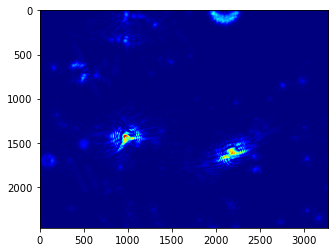

In [1536]:
V = np.sum(np.lib.stride_tricks.sliding_window_view(T_padded, (n,n)), axis=(2,3))/n**2

plt.tight_layout()
plt.imshow(V, cmap = 'jet');

np.mean(V)

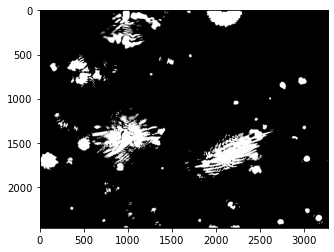

In [1537]:
tau = 0.002    # threshold
mask = (V > tau).astype(int)

plt.tight_layout()
plt.imshow(mask, cmap = 'gray');

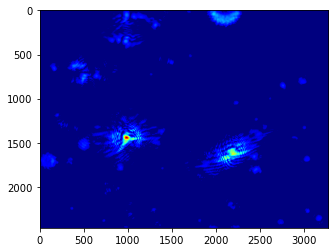

In [1538]:
R_S = R_TI*mask

plt.tight_layout()
plt.imshow(R_S, cmap = 'jet');

## Propagate to the hologram plane

In [1539]:
z = d

# Propagate to the twin image using the Angular Spectrum Method (ASM)
G = np.exp((1j*2*np.pi*z)*np.sqrt(1/(Lambda**2) - Fx**2 - Fy**2))

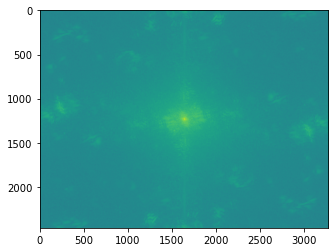

In [1540]:
FimG = fftshift(fft2(R_S))
# FimgH = FimgH - np.mean(FimgH) 

plt.tight_layout()
plt.imshow(np.log(abs(FimG)))

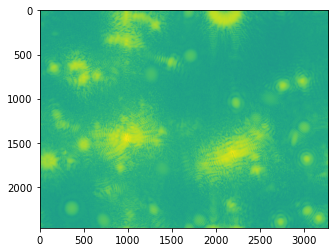

In [1541]:
t2 = (ifft2(fftshift(FimG*G)))

plt.tight_layout()
plt.imshow(np.log(abs(t2)))

In [1542]:
# display results
amp2 = (abs(t2))                   # amplitude
phi2 = np.angle(-t2)              # wrapped phase
UnimgH2 = -unwrap_phase(phi2)     # unwrapped phase

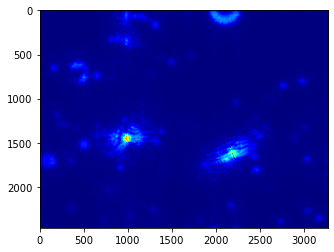

In [1543]:
# Visualize the amplitude
plt.tight_layout()
plt.imshow(amp2, cmap='jet')
#plt.colorbar()
#plt.title('amplitude with no twin-image')
plt.savefig('amp.tif')

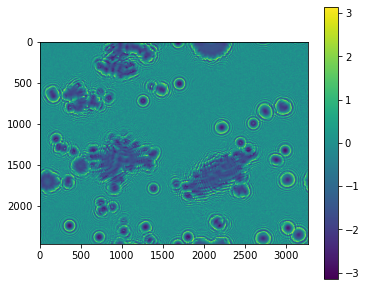

In [1544]:
# Visualize the phase 
#plt.tight_layout()
plt.figure(figsize=(6,5))
plt.imshow(phi2)
plt.colorbar()
#plt.title('wrapped phase with no twin-image')
plt.savefig('phi.tif') # To save the plot to a file

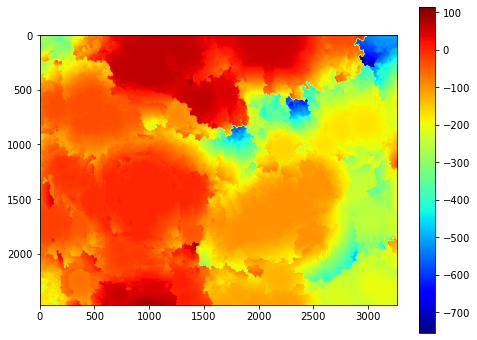

In [1545]:
# Visualize the phase 
#plt.tight_layout()
plt.figure(figsize=(8,6))
plt.imshow(UnimgH2, cmap = 'jet')
plt.colorbar()
#plt.title('unwrapped phase of 2.5 $\mu$m beads')
plt.savefig('phase.tif') # To save the plot to a file

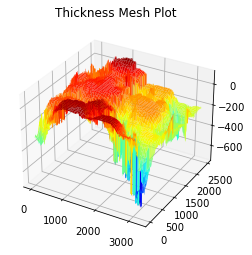

In [1546]:
# Thickness calculation

wavelength = 0.488
ri_bead = 1.430
ri_med = 1.510
ref_index_diff = abs(ri_bead - ri_med)
factor = wavelength / (2 * np.pi * ref_index_diff)
thickness = factor * UnimgH2

# Plotting the thickness as a mesh plot
fig = plt.figure(8)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(0, thickness.shape[1], 1)
Y = np.arange(0, thickness.shape[0], 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, thickness, cmap='jet')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Thickness')
ax.set_title('Thickness Mesh Plot')
plt.savefig('3D.tif')
plt.show()

